## Fitting PPXF to one mock - example notebook

This notebook exemplifies how to read one mock from the mini mocha challenge, using the GQP_MC tools, and fit it with PPXF using two simple templates. 

Notes:

 * The example fits to a noiseless spectra. Both templates and the noiseless spectra were constructed with the same SPS library (BC03/stelib), so we don't worry about instrumental mismatch of LSF. This also means we don't worry about merging the three independent arms of DESI spectra.
 * The templates that are used as input to PPXF are two simple templates, one a bulge-like component, and one a disk-like component (described here: https://desi.lbl.gov/trac/wiki/GalaxiesWG/spectral_challenge#Simplemocks)
 * The example fits one kinematic component (the mocks have two - as bulge and disk are assumed to have different values of velocity dispersion)
 
 * Lots of very useful examples on how to run PPXF are provided with the installation (depending on how you installed PPXF, this will be in a different place. I copied them and put them on under doc/ppxf_examples/)

* For some reason, np.pad() on the numpy version that I'm running, insists on the keyword 'mode' being set. If, when running ppxf, it hangs because of that, just edit the two lines in ppxf.py that use np.pad() and add mode='constant' to the np.pad() command.


In [1]:
import sys 
import os 
import h5py 
import numpy as np 
from astropy.io import fits

# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
# --- gqp_mc ---
from gqp_mc import util as UT 
from gqp_mc import data as Data 
#from gqp_mc import fitters as Fitters

import fsps

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import glob
from time import perf_counter as clock

ppxf_dir = os.path.dirname(os.path.realpath(ppxf_package.__file__))
print("ppxf installed here: ", ppxf_dir)

from platform import python_version
print("python version: ", python_version())

ppxf installed here:  /global/u2/r/rtojeiro/mydesi/lib/python3.6/site-packages/ppxf
python version:  3.6.6


We'll define some functions to use later on

In [2]:
import specsim

## Getting the RMS dispersion for the DESI spectrographs from specsim

In [3]:
import specsim.config
import specsim.instrument

In [4]:
#load DESI spectrographs configuration
config = specsim.config.load_config('desi')

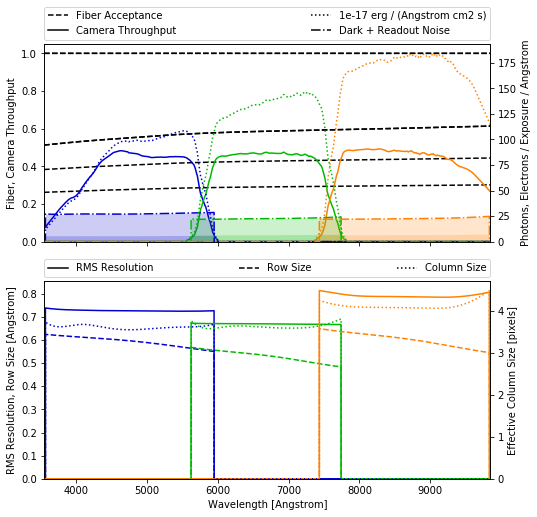

In [5]:
#summary plot of technical specs. we are interested in the RMS resolution 
specsim.instrument.initialize(config).plot()

In [6]:
#to access those values directly, for each of the arms:
instrument = specsim.instrument.initialize(config)
    
wavelength_blue = instrument.cameras[0]._wavelength 
rms_res_blue = instrument.cameras[0].rms_resolution.to(instrument._wavelength.unit).value

wavelength_green = instrument.cameras[1]._wavelength 
rms_res_green = instrument.cameras[1].rms_resolution.to(instrument._wavelength.unit).value

wavelength_red = instrument.cameras[2]._wavelength
rms_res_red = instrument.cameras[2].rms_resolution.to(instrument._wavelength.unit).value


Text(0,0.5,'RMS resolution')

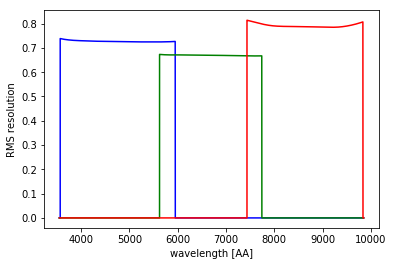

In [7]:
plt.plot(wavelength_blue,rms_res_blue, color='blue')
plt.plot(wavelength_green,rms_res_green, color='green')
plt.plot(wavelength_red,rms_res_red, color='red')
plt.xlabel('wavelength [AA]')
plt.ylabel('RMS resolution')

In [8]:
print('blue arm goes between ' + str(wavelength_blue[rms_res_blue > 0][0]) + ' and ' + str(wavelength_blue[rms_res_blue > 0][-1]) + 'AA')
print('green arm goes between ' + str(wavelength_green[rms_res_green > 0][0]) + ' and ' + str(wavelength_green[rms_res_green > 0][-1]) + 'AA')
print('red arm goes between ' + str(wavelength_red[rms_res_red > 0][0]) + ' and ' + str(wavelength_red[rms_res_red > 0][-1]) + 'AA')

blue arm goes between 3569.0 and 5949.0AA
green arm goes between 5625.0 and 7741.0AA
red arm goes between 7435.0 and 9834.0AA


## Setting up functions and templates for ppxf runs

In [9]:
#simple bulge and disk templates
def read_simple_templates(velscale, lamrange):

    hdul = fits.open(UT.lgal_dir()+"/simple_mocks/template_fluxbc03.fits")
    wave_s = hdul[1].data['wave']
    flux_bulge = hdul[1].data['L_bulge']
    flux_disk = hdul[1].data['L_disk']
    hdul.close()
    
    wave,flux_bulge = to_common_grid(wave_s, flux_bulge)
    wave,flux_disk = to_common_grid(wave_s, flux_disk)

    mask = ((wave >= lamrange[0]) & (wave <= lamrange[1]))
    wave = wave[mask]
    
    flux_bulge = flux_bulge[mask]
    model1, logLam1, velscale_out = util.log_rebin([wave[0], wave[-1]], flux_bulge, velscale=velscale)
    model1 /= np.median(model1)
    print(velscale, velscale_out)
    flux_disk = flux_disk[mask]
    model2, logLam2, velscale_out = util.log_rebin([wave[0], wave[-1]], flux_disk, velscale=velscale)
    model2 /= np.median(model2)
    
    templates = np.column_stack([model1, model2])
    #print([wave[0], wave[-1]])
    
    plt.plot(np.exp(1)**logLam1, model1)
    plt.plot(np.exp(1)**logLam2, model2)
           
    return (logLam1, templates)
    
    

In [10]:
def make_ssp_templates(velscale, lamrange,ages, metallicities):
    
    #initialise FSPS models
    sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1,
                                sfh=0)  
    
    #total number of templates
    N = len(ages) * len(metallicities)
    
    #get the wavelength vector and initialise the array to hold all the templates
    wave = set_common_grid()
    templates = np.zeros((len(wave), N))
    
    #now loop through the given metallicities and ages to create each template in turn
    c=0
    for Z in metallicities:
        sp.params['logzsol']=Z
        for age in ages:
            wave_fsps, flux_fsps = sp.get_spectrum(tage=age,peraa=True) #in L_solar/AA
            #now to common grid
            wave, flux = to_common_grid(wave_fsps, flux_fsps)
            templates[:,c] = flux/np.median(flux)
            c=c+1
        
    #now mask and re-grid
    mask = ((wave >= lamrange[0]) & (wave <= lamrange[1]))
    wave = wave[mask]  
    template_rb, logLam, velscale_out = util.log_rebin([wave[0], wave[-1]], templates[mask,0], velscale=velscale)
        
    templates_out = np.zeros((len(logLam), N))
    templates_out[:,0] = template_rb
    plt.plot(np.exp(1)**logLam, templates_out[:,0]/np.median(templates_out[:,0]))
    for i in range(1,N):
        templates_out[:,i], logLam, velscale_out = util.log_rebin([wave[0], wave[-1]], templates[mask,i], velscale=velscale)
        plt.plot(np.exp(1)**logLam, templates_out[:,i])
    return logLam, templates_out
     

In [11]:
def set_common_grid():
    #change as needed
    return np.linspace(wave_i,wave_f, (wave_f-wave_i+1))
 

In [12]:
def to_common_grid(wave,flux):
    wave_grid = set_common_grid()
    flux_grid = np.interp(wave_grid, wave, flux)
    print(flux_grid)
    return wave_grid, flux_grid
    

In [13]:
def read_BSG_mocks(noise='none', sample='mini_mocha'):

    meta, mock = Data.read_data(noise=noise, sample='mini_mocha')
    
    iobs = int(noise.strip('bgs'))    
    
    wave_b = mock['spec_wave_b_bgs'][:]
    wave_g = mock['spec_wave_r_bgs'][:]
    wave_r = mock['spec_wave_z_bgs'][:]

    flux_b = mock['spec_flux_b_bgs'][...][iobs,:,:][:]
    flux_g = mock['spec_flux_r_bgs'][...][iobs,:,:][:]
    flux_r = mock['spec_flux_z_bgs'][...][iobs,:,:][:]

    return wave_b, wave_g, wave_r, flux_b, flux_g, flux_r, meta
    

Reading the (mock) data, using the tools provided by gqp_mc

For noiseless templates (note, the meta data is the same for the noiseless and BGS mocks)

In [14]:
spec_s, meta = Data.Spectra(noise='none', sample='mini_mocha') #noiseless spectra 

print(spec_s.keys())
print(meta.keys())

dict_keys(['frac_fiber', 'wave', 'flux', 'flux_unscaled'])
dict_keys(['galid', 't_lookback', 'sfh_disk', 'sfh_bulge', 'Z_disk', 'Z_bulge', 'logM_disk', 'logM_bulge', 'logM_total', 't_age_MW', 'Z_MW', 'redshift', 'cosi', 'tau_ism', 'tau_bc', 'vd_disk', 'vd_bulge', 'logM_fiber', 'airmass', 'moon_alt', 'moon_ill', 'moon_sep', 'seeing', 'sun_alt', 'sun_sep', 'texp_total', 'transp', 'wave_sky', 'sbright_sky', 'sfr_1gyr', 'sfr_100myr'])


This is the assumed relationship between velocity dispersion and bulge mass in the mocks

Text(0,0.5,'vel dispersion bulge [km/s]')

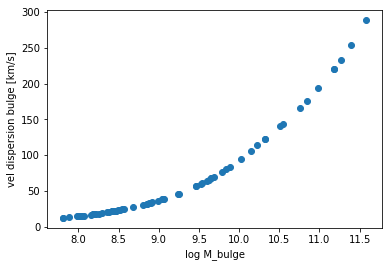

In [15]:
plt.scatter(meta['logM_bulge'], meta['vd_bulge'])
plt.xlabel('log M_bulge')
plt.ylabel('vel dispersion bulge [km/s]')

Pick a galaxy with a large velocity dispersion to make things easy to start with

In [16]:
g = np.where(meta['vd_bulge'] > 200)[0][0] #galaxy number to look at
z = meta['redshift'][g]
vdisp_bulge = meta['vd_bulge'][g]
vdisp_disk = meta['vd_disk'][g]
print('galaxy #' + str(g) + ' is at redshift ' + str(z) + ' with vel disp for bulge and disk of ' + str(vdisp_bulge) + ' and ' + str(vdisp_disk))

galaxy #35 is at redshift 0.3653412 with vel disp for bulge and disk of 253.4563457408788 and 50.0


In [17]:
#sort the data in ascending order of wavelength
#wsort_s = np.argsort(spec_s['wave'])
wave = spec_s['wave'][0]/(1 + z) #rest-frame wavelength

flux_gal = spec_s['flux'][g]


Text(0,0.5,'Flux')

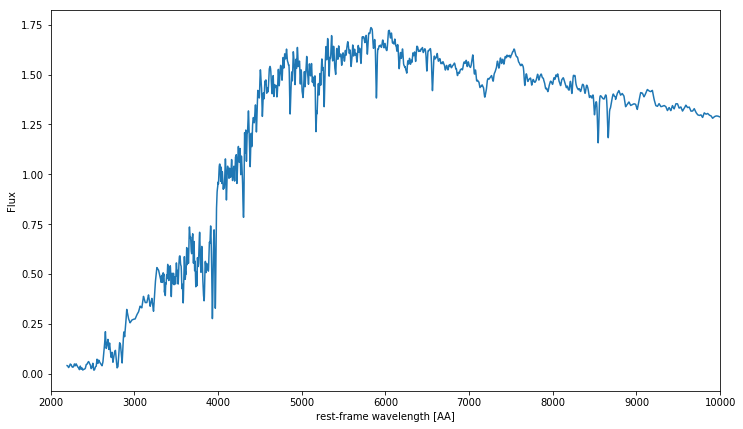

In [18]:
plt.figure(figsize=(12,7))
plt.plot(wave, flux_gal)
plt.xlim(2000,10000)
plt.xlabel('rest-frame wavelength [AA]')
plt.ylabel('Flux')

For DESI mocks, we get the wavelength and flux of each arm individually

In [19]:
wave_b, wave_r, wave_z, flux_b, flux_r, flux_z, _ = read_BSG_mocks(noise='bgs6', sample='mini_mocha') #noise, conditions set number 6

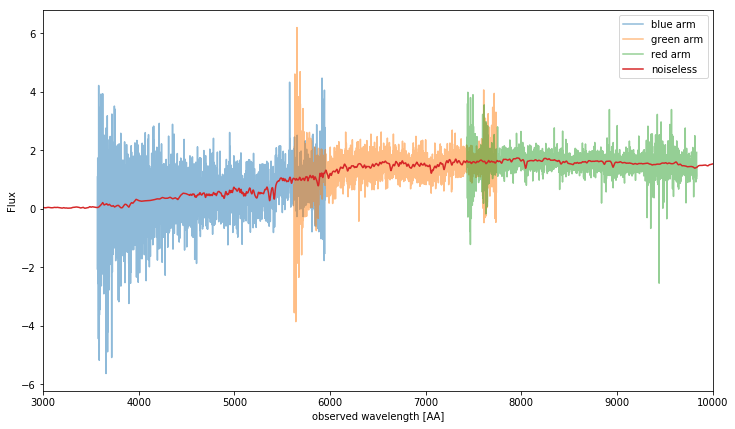

In [20]:
#plotting the flux from the 3 arms in the same plot, and the noiseless flux over

plt.figure(figsize=(12,7))

plt.plot(wave_b, flux_b[g], label='blue arm', alpha=0.5)
plt.plot(wave_r, flux_r[g], label = 'green arm', alpha=0.5)
plt.plot(wave_z, flux_z[g], label='red arm', alpha=0.5)

plt.plot(spec_s['wave'][0], spec_s['flux'][g], label='noiseless')

plt.xlim(3000, 10000)
plt.xlabel('observed wavelength [AA]')
plt.ylabel('Flux')
plt.legend()

## running ppxf in the noiseless templates

From here on, the examples are on the noiseless templates only

Interpolate the spectrum to a common grid. We'll do this to the models, too.

In [21]:
wave_i = 3600
wave_f = 6500

In [22]:
wave_gal,flux_gal = to_common_grid(wave, flux_gal)
print(np.shape(flux_gal))

[0.57793371 0.56492499 0.54801292 ... 1.52632492 1.53384526 1.54302879]
(2901,)


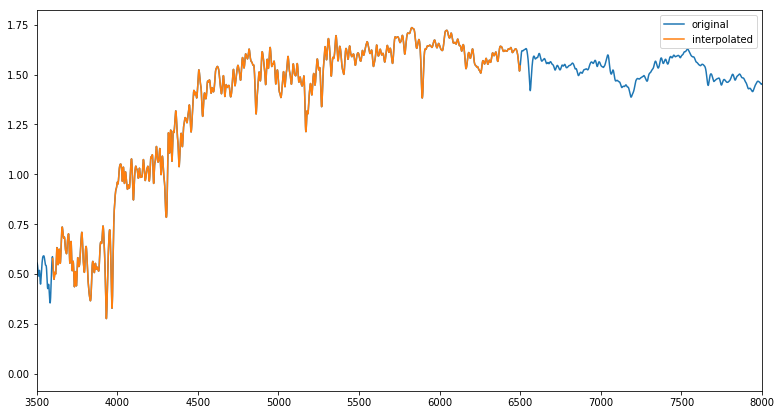

In [23]:
#a sanity check plot
plt.figure(figsize=(13,7))
plt.plot(spec_s['wave'][0]/(1+z), spec_s['flux'][g], label='original')
plt.plot(wave_gal, flux_gal, label='interpolated')
plt.xlim(3500,8000)
plt.legend()

In [24]:
#cut to a small range in rest-frame wavelength for now
lam_bounds = [wave_i, wave_f]
mask = ((wave_gal >= lam_bounds[0]) & (wave_gal <= lam_bounds[1]))
flux_gal = flux_gal[mask]
wave_gal = wave_gal[mask]

lamrange= [wave_gal[0], wave_gal[-1]]
print(lamrange, np.shape(wave_gal))

[3600.0, 6500.0] (2901,)


Compute velocity scale and rebin in log_lambda

In [25]:
c = 299792.458                  # speed of light in km/s
frac = wave_gal[1]/wave_gal[0]  # Constant lambda fraction per pixel
velscale = np.log(frac)*c       # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
print('velocity scale = ', velscale)

velocity scale =  83.26411885215646


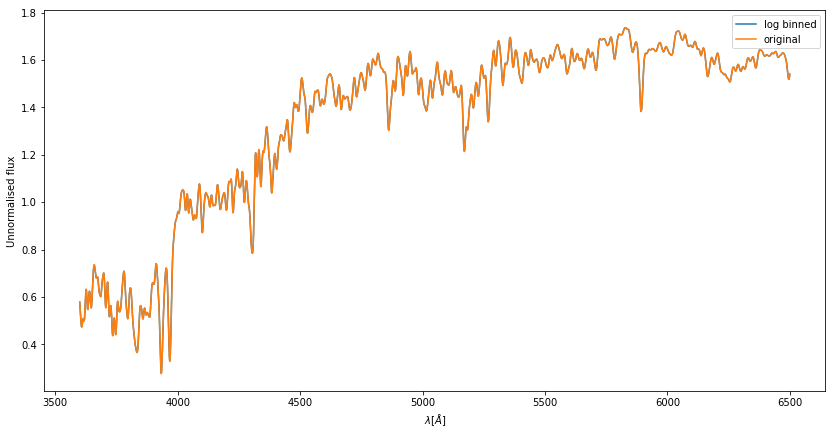

In [26]:
galaxy, logLam_gal, velscale = util.log_rebin(lamrange, flux_gal, velscale=velscale)

#plot original and rebinned spectra to make sure they match
plt.figure(figsize=(14,7))
plt.plot(np.exp(1)**logLam_gal, galaxy, label='log binned')
plt.plot(wave_gal, flux_gal, label='original')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('Unnormalised flux')
plt.legend()

#working vectors now are galaxy and lam_log both rebinned in equal bins in log_lambda
lam_gal = np.exp(1)**logLam_gal

In [27]:
len(logLam_gal)

2128

Read templates. The read_simple_templates() function already puts them in a common grid in log lambda

[3.01289033e+21 2.82018356e+21 2.57254762e+21 ... 7.95993105e+21
 8.11072473e+21 8.26304455e+21]
[4.27998600e+22 4.19589026e+22 4.11411336e+22 ... 3.73568054e+22
 3.79599803e+22 3.85457217e+22]
83.26411885215646 83.26411885215646
83.26411885215646


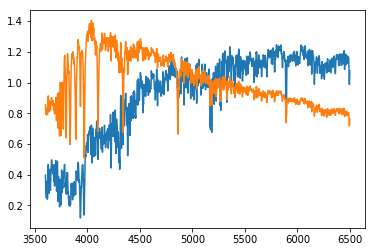

In [28]:
(loglam_temp, templates_simple) = read_simple_templates(velscale,lam_bounds)
lam_temp = np.exp(1)**loglam_temp
lamRange_temp = [np.exp(1)**loglam_temp[0],np.exp(1)**loglam_temp[-1]]
print(velscale)

In [29]:
#sanity checks - these should all match
print(lam_temp[0],lam_gal[0])
print(lam_temp[-1],lam_gal[-1])
print(np.shape(lam_temp), np.shape(lam_gal))

3599.999895842976 3599.999895842976
6499.2390763432295 6499.2390763432295
(2128,) (2128,)


Alternative templates: in this case a grid of 3 ages at two metallicities

[0.00114729 0.0011466  0.00114395 ... 0.00059841 0.00060473 0.0006123 ]
[0.00012605 0.00012819 0.00012849 ... 0.00014469 0.00014737 0.0001501 ]
[1.42843128e-05 1.46766291e-05 1.47251233e-05 ... 2.64060539e-05
 2.71943160e-05 2.77446164e-05]
[0.00106128 0.001065   0.00106403 ... 0.00055356 0.00056275 0.00057353]
[9.15996860e-05 9.31648352e-05 9.32123015e-05 ... 1.18445146e-04
 1.21960083e-04 1.25443308e-04]
[7.26894948e-06 7.54915413e-06 7.61887133e-06 ... 1.79907325e-05
 1.88115860e-05 1.92883850e-05]


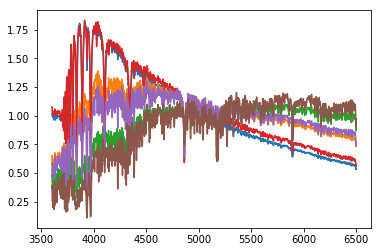

In [30]:
ages = [0.1, 1, 10] #in Gyrs
Z = [-0.5, 0] #in log10(Z/Zsolar)
loglam_temp_ssp, templates_ssp = make_ssp_templates(velscale,lam_bounds, ages, Z)

In [31]:
#Lifted straight out of the ppxf examples. Note dv should be zero here as we're working on a fixed grid.

# The galaxy and the template spectra do not have the same starting wavelength.
# For this reason an extra velocity shift DV has to be applied to the template
# to fit the galaxy spectrum. We remove this artificial shift by using the
# keyword VSYST in the call to PPXF below, so that all velocities are
# measured with respect to DV. This assume the redshift is negligible.
# In the case of a high-redshift galaxy one should de-redshift its
# wavelength to the rest frame before using the line below (see above).
#
c = 299792.458   # km/s
dv = c*np.log(lam_temp[0]/lam_gal[0])    # eq.(8) of Cappellari (2017)
print(dv)
goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, z)



0.0


[0, 200.0]
Best Fit:       Vel     sigma
 comp. 0:        35       223
chi2/DOF: 0.0003873
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
Nonzero (>0.1%) Templates: 2 / 2
Templates weights:
      1.28    0.0731
Formal errors:
     dV    dsigma   dh3      dh4
     2.3     2.4
Elapsed time in PPXF: 0.06 s


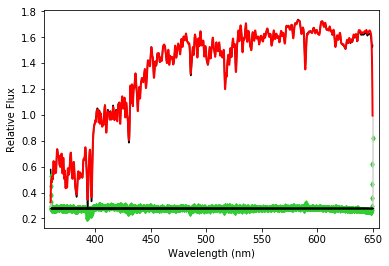

In [32]:
#Ditto.

# Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
#
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [0, 200.]  # (km/s), starting guess for [V, sigma]
print(start)
noise=np.ones_like(galaxy)
t = clock()

pp = ppxf(templates_simple, galaxy,noise, velscale, start,plot=True, \
          moments=2, degree=4, vsyst=dv, clean=False, lam=lam_gal)

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

print('Elapsed time in PPXF: %.2f s' % (clock() - t))

Best Fit:       Vel     sigma
 comp. 0:       -38       241
chi2/DOF: 0.0007274
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
Nonzero (>0.1%) Templates: 3 / 6
Templates weights:
  3.05e-16 -1.67e-16     0.108         0     0.133      1.08
Formal errors:
     dV    dsigma   dh3      dh4
     3.3     3.4
Elapsed time in PPXF: 0.26 s


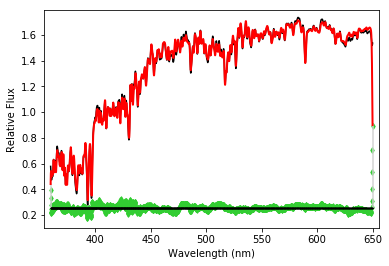

In [33]:
pp = ppxf(templates_ssp, galaxy,noise, velscale, start,plot=True, \
          moments=2, degree=4, vsyst=dv, clean=False, lam=lam_gal)

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

print('Elapsed time in PPXF: %.2f s' % (clock() - t))